## EDA

In [1]:
!wget http://158.109.8.102/AppaRealAge/appa-real-release.zip
!unzip appa-real-release.zip -d ./

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: ./appa-real-release/test/007580.jpg  
  inflating: ./appa-real-release/test/007263.jpg  
  inflating: ./appa-real-release/test/006471.jpg  
  inflating: ./appa-real-release/test/005662.jpg.mat  
  inflating: ./appa-real-release/test/005781.jpg  
  inflating: ./appa-real-release/test/006207.jpg.mat  
  inflating: ./appa-real-release/test/006199.jpg  
  inflating: ./appa-real-release/test/006799.jpg  
  inflating: ./appa-real-release/test/006339.jpg.mat  
  inflating: ./appa-real-release/test/006214.jpg  
  inflating: ./appa-real-release/test/006340.jpg_face.jpg  
  inflating: ./appa-real-release/test/006447.jpg.mat  
  inflating: ./appa-real-release/test/007244.jpg  
  inflating: ./appa-real-release/test/007017.jpg_face.jpg  
  inflating: ./appa-real-release/test/006012.jpg  
  inflating: ./appa-real-release/test/006892.jpg_face.jpg  
  inflating: ./appa-real-release/test/007362.jpg_face.jpg  
  inflating: 

In [6]:
import warnings
warnings.filterwarnings('ignore')

In [1]:
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import  Dense, Flatten, MaxPooling2D, Conv2D, AvgPool2D, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
datagen = ImageDataGenerator(rescale=1./255)
gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [3]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [10]:
print('Min age: ',labels.min())
print('Max age: ',labels.max())

Min age:  file_name    000000.jpg
real_age              1
dtype: object
Max age:  file_name    007612.jpg
real_age            100
dtype: object


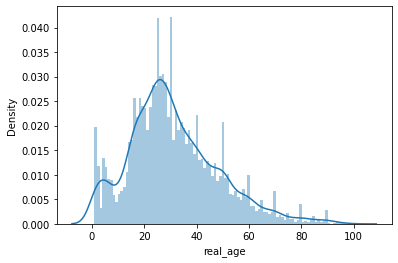

In [9]:
sns.distplot(labels["real_age"],  hist = True, bins=100)
plt.show()

<AxesSubplot:xlabel='real_age'>

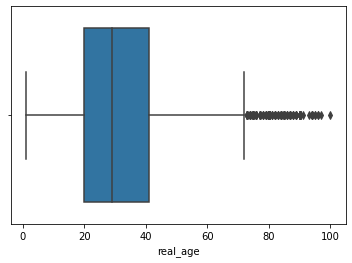

In [8]:
sns.boxplot(labels["real_age"])

In [27]:
features, target = next(gen_flow)

In [28]:
features.shape

(32, 224, 224, 3)

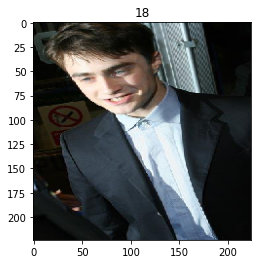

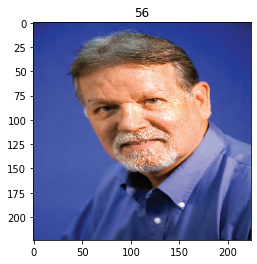

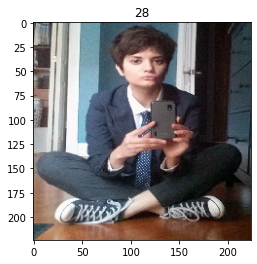

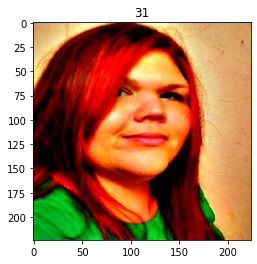

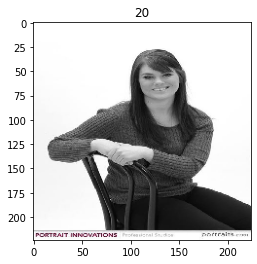

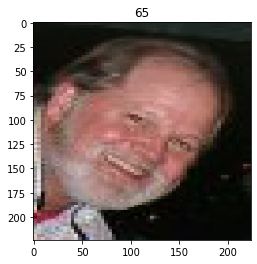

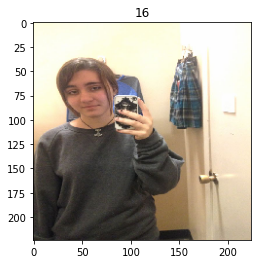

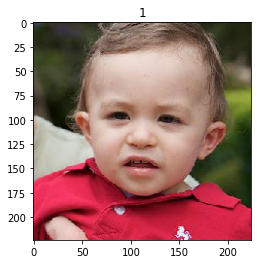

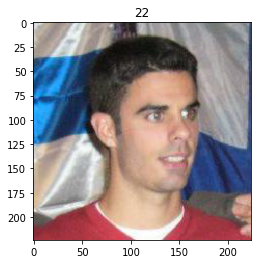

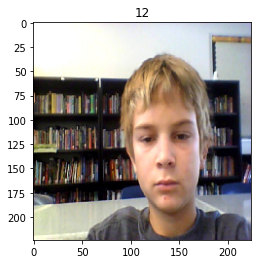

In [29]:
for age, photo in zip(target[:10], features[:10]):
    plt.figure()
    plt.title(age)
    plt.imshow(photo)

Итак, у нас есть повернутые изображения, поэтому мы должны добавить изображения с вращением в процессе обучения размером 224x224, также у нас есть изображения в оттенках серого цвета

In [39]:
photo.shape

(224, 224, 3)

Подводя итоги по исследовательскому анализу данных можно отметить, что:
1. Фотографий недостаточно, ибо в оригинальном датсете около 100 тысяч и за счет этого можно улучшить способность модели к генерализации
2. В датасете искаженное распределение возраста. Минимальный возраст - год, а максимальный 100 лет. В выборке представлено больше всего людей в возрасте около 30 лет. Так же видны всплески в юбилейные года. 
3. На черно-белых фото можно отметить слабый контраст лица, а так же посторонние надписи. На некоторых селфи телефон закрывает часть лица, что так же мешает модели
4. Рекомендованные аугментации: попробовать изменить насыщенность, яркость изображений, а так же градацию серого цвета, поскольку это поможет в обучении модели

##  Model Fitting

(Код в этом разделе запускается в отдельном GPU-тренажёре)

Загрузим данные:

Примени модель ResNet50 добавив сверху полносвязный слой с Relu активацией. Веса imagenet использовать не будем, так как там задача классификации
Обучим модель на 10 эпохах и посмотрим кривые обучения

In [33]:
def load_train(path):
    labels = pd.read_csv(path+'gt_train.csv')
    labels = labels.drop(['apparent_age',
                   'worker_age', 
                   'worker_gender'], axis=1)
    train_datagen = ImageDataGenerator(rescale= 1./255, validation_split=0.25)
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe = labels,
        directory = path + 'train/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        horizontal_flip=True,
        seed=42)
    return train_datagen_flow

In [35]:
def load_test(path):
    labels = pd.read_csv(path+'gt_test.csv')
    labels = labels.drop(['apparent_age',
                   'worker_age', 
                   'worker_gender'], axis=1)
    test_datagen = ImageDataGenerator(rescale= 1./255, validation_split=0.25)
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe = labels,
        directory = path + 'test/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=42)

    return test_datagen_flow

In [43]:
def create_model(input_shape):

    backbone = ResNet50(input_shape= input_shape,
                    weights='imagenet',
                    include_top= False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    optimizer = Adam(learning_rate=0.0005)
    model.compile(optimizer=optimizer, loss='mean_squared_error',metrics=['mae'])
    return model

In [44]:
model = create_model((224, 224, 3))

In [48]:
def train_model(model, train_data, test_data, batch_size=None, epochs=5,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    model.fit(train_data,
              validation_data= test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    return model

Train for 178 steps, validate for 60 steps

Epoch 1/10
2022-12-05 19:32:32.589775: 
178/178 - 64s - loss: 181.4096 - mae: 10.0604 - val_loss: 462.7790 - val_mae: 16.3331

Epoch 2/10
178/178 - 47s - loss: 101.7775 - mae: 7.6626 - val_loss: 458.4215 - val_mae: 16.2475

Epoch 3/10
178/178 - 47s - loss: 68.4626 - mae: 6.3245 - val_loss: 318.6740 - val_mae: 13.2430

Epoch 4/10
178/178 - 46s - loss: 43.0611 - mae: 5.0570 - val_loss: 238.1105 - val_mae: 11.2777

Epoch 5/10
178/178 - 49s - loss: 32.0781 - mae: 4.3614 - val_loss: 201.3604 - val_mae: 11.2951

Epoch 6/10
178/178 - 47s - loss: 23.0121 - mae: 3.7532 - val_loss: 78.3699 - val_mae: 6.7741

Epoch 7/10
178/178 - 39s - loss: 17.4581 - mae: 3.2150 - val_loss: 75.2920 - val_mae: 6.6131

Epoch 8/10
178/178 - 51s - loss: 13.7119 - mae: 2.8488 - val_loss: 99.7448 - val_mae: 7.8042

Epoch 9/10
178/178 - 68s - loss: 10.9184 - mae: 2.5560 - val_loss: 79.8386 - val_mae: 6.9684

Epoch 10/10
178/178 - 72s - loss: 9.0685 - mae: 2.3157 - val_loss: 70.8855 - val_mae: 6.4620


60/60 - 11s - loss: 70.8855 - mae: 6.4620

Test MAE: 6.4620

## Анализ обученной модели

В качетсве итоговой модели была выбрана ResNet50, с последующей заменой финального слоя для задачи регресси. ResNet — это глубокая сеть, которая применяет skip-connections, свёртки небольшого размера и bottleneck-блоки. На большинстве задач она работает лучше других архитектур.

При использовании данной модели, получили необходимую метрику MAE: моя модель предсказывает возраст с ошибкой ~ до 6,46 лет.

Данную модель можно использовать в бизнесе, но стоит обращать внимание на предсказывание модели для детей. Скорее всего данная модель не поможет в определении в определнии возраста покупателя для продажи алкоголя.

В плане накопления данных для определенных возрастных групп - тут стоит быть более аккуратным, так как средняя ошибка - 6,46 лет.